# Notebook to fix the false positives in the KChip models

In [1]:
import pathlib
import pandas as pd

## Identify the model-media combinations that result in false positives

### Get the experimental growth values

In [2]:
from kchip_utils import read_experimental_yield

In [3]:
met_profile_file = pathlib.Path("../../data/raw/kchip/media/metabolic_profiles.csv")
exp_yield = read_experimental_yield(met_profile_file)
exp_yield_binary = exp_yield.map(lambda x: 1 if x > 0.2 else 0).astype(int)

In [4]:
true_positives = {row_label: exp_yield_binary.columns[row == 1].to_list() for row_label, row in exp_yield_binary.iterrows()}
true_positives

{'PAl': ['Glycerol',
  'Glutamine',
  'Cellobiose',
  'Mannose',
  'Trehalose',
  'Glucose',
  'Mix',
  'Pyruvate',
  'Alanine',
  'Fructose',
  'Ribose',
  'Xylose',
  'Mannitol',
  'L-Arabinose',
  'Sorbitol',
  'Lactose',
  'Sucrose',
  'Citrate',
  'Fumarate',
  'Succinate',
  'Proline'],
 'PAg2': ['Glycerol',
  'Glutamine',
  'Rhamnose',
  'Maltose',
  'Mannose',
  'GlcNAc',
  'Trehalose',
  'Glucose',
  'Mix',
  'Pyruvate',
  'Alanine',
  'Fructose',
  'Ribose',
  'Xylose',
  'Mannitol',
  'L-Arabinose',
  'Sucrose',
  'Fumarate',
  'Succinate',
  'Proline'],
 'PAg1': ['Glycerol',
  'Glutamine',
  'Cellobiose',
  'Rhamnose',
  'Maltose',
  'Mannose',
  'GlcNAc',
  'Trehalose',
  'Glucose',
  'Mix',
  'Pyruvate',
  'Alanine',
  'Fructose',
  'Galactose',
  'Ribose',
  'Xylose',
  'Mannitol',
  'L-Arabinose',
  'Sucrose',
  'Citrate',
  'Fumarate',
  'Succinate',
  'Proline'],
 'PAg3': ['Glycerol',
  'Glutamine',
  'Cellobiose',
  'Rhamnose',
  'Maltose',
  'Mannose',
  'GlcNAc',
 

### Load models and media

In [5]:
from kchip_utils import load_models_and_media, simulate_predicted_growth

In [6]:
models_folder = pathlib.Path("../../data/processed/kchip/models")
media_folder = pathlib.Path("../../data/processed/kchip/media")
model_dict, media_dict = load_models_and_media(models_folder, media_folder)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


In [7]:
CSOURCE_ID = 17
carbon_sources = dict(sorted({k: v[CSOURCE_ID:] for k, v in media_dict.items()}.items()))

In [8]:
pred_growth = simulate_predicted_growth(model_dict, media_dict, carbon_sources)
pred_growth_binary = pred_growth.map(lambda x: 1 if x > 0.1 else 0).astype(int)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__

In [9]:
exp_data = exp_yield_binary
row_labels = exp_data.index
col_labels = exp_data.columns
pred_data = pred_growth_binary.loc[row_labels, col_labels]

In [10]:
from kchip_utils import plot_confusion_matrix

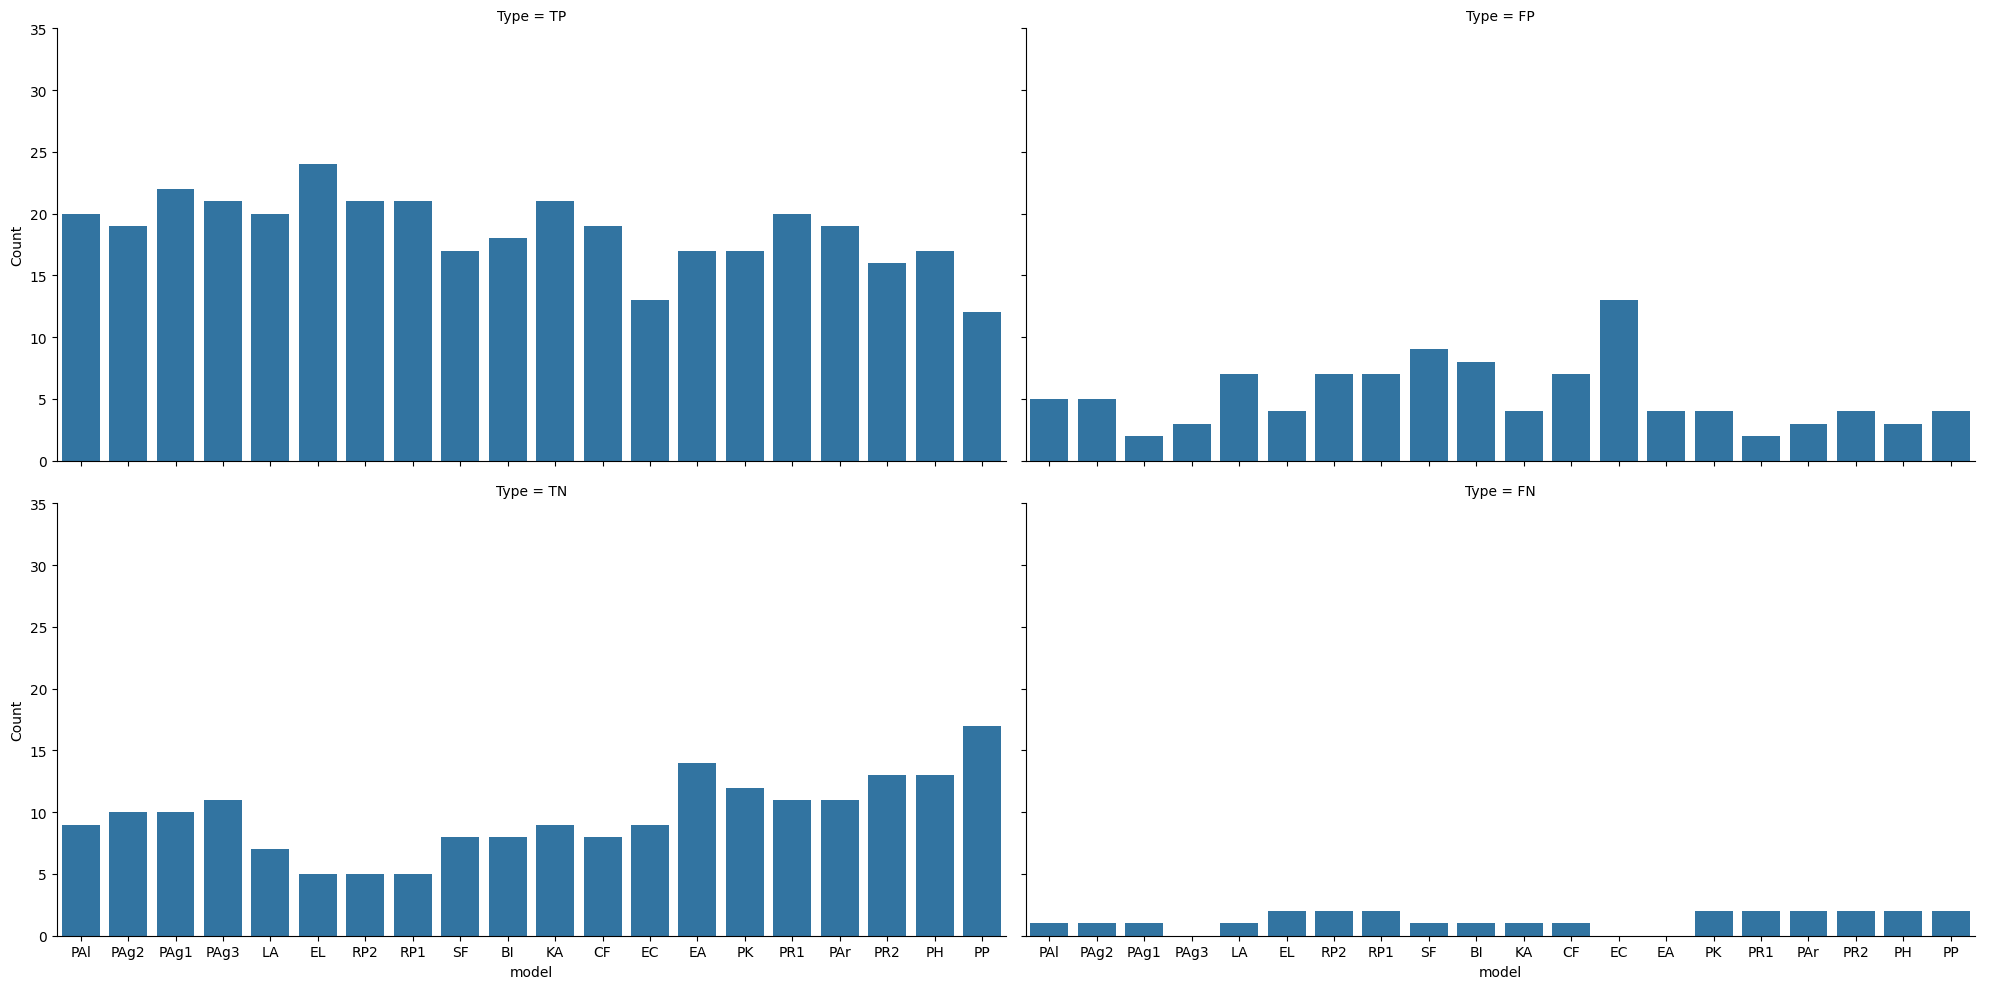

In [11]:
plot_confusion_matrix(pred_data, exp_data)

## Fix the models

### Find false positives

In [12]:
false_positives: dict[str, list[str]] = {}
for row_label in pred_data.index:
    false_positives[row_label] = []
    for col_label in pred_data.columns:
        pred = pred_data.loc[row_label, col_label]
        exp = exp_data.loc[row_label, col_label]
        if pred > 0 and exp == 0:
            false_positives[row_label].append(col_label)

### Remove exchanges from the models for these false positives

In [13]:
new_model_dict = dict()
for model_name, model in model_dict.items():
    new_model = model.copy()
    for fp_media in false_positives[model_name]:
        for compounds_to_remove in carbon_sources[fp_media]:
            reaction = f"EX_{compounds_to_remove}_e0"
            new_model.remove_reactions(reaction)
    new_model_dict[model_name] = new_model

/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/core/model.py:777: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [14]:
ec_model = model_dict["EC"]
ec_model_new = new_model_dict["EC"]

In [15]:
len(ec_model.reactions), len(ec_model_new.reactions)

(1848, 1835)

In [23]:
set(ec_model.medium.keys()) - set(ec_model_new.medium.keys())

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__

{'EX_cpd00035_e0',
 'EX_cpd00036_e0',
 'EX_cpd00051_e0',
 'EX_cpd00053_e0',
 'EX_cpd00054_e0',
 'EX_cpd00105_e0',
 'EX_cpd00106_e0',
 'EX_cpd00129_e0',
 'EX_cpd00137_e0',
 'EX_cpd00158_e0',
 'EX_cpd00179_e0',
 'EX_cpd00249_e0',
 'EX_cpd00396_e0'}

### Simulate again and verify

In [16]:
fixed_pred_growth = simulate_predicted_growth(new_model_dict, media_dict, carbon_sources)
fixed_pred_growth_binary = pred_growth.map(lambda x: 1 if x > 0.1 else 0).astype(int)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/home/dileep/Documents/Work/KBaseCollaborations/CommScores/.venv/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__

In [17]:
exp_data = exp_yield_binary
row_labels = exp_data.index
col_labels = exp_data.columns
pred_data = fixed_pred_growth_binary.loc[row_labels, col_labels]

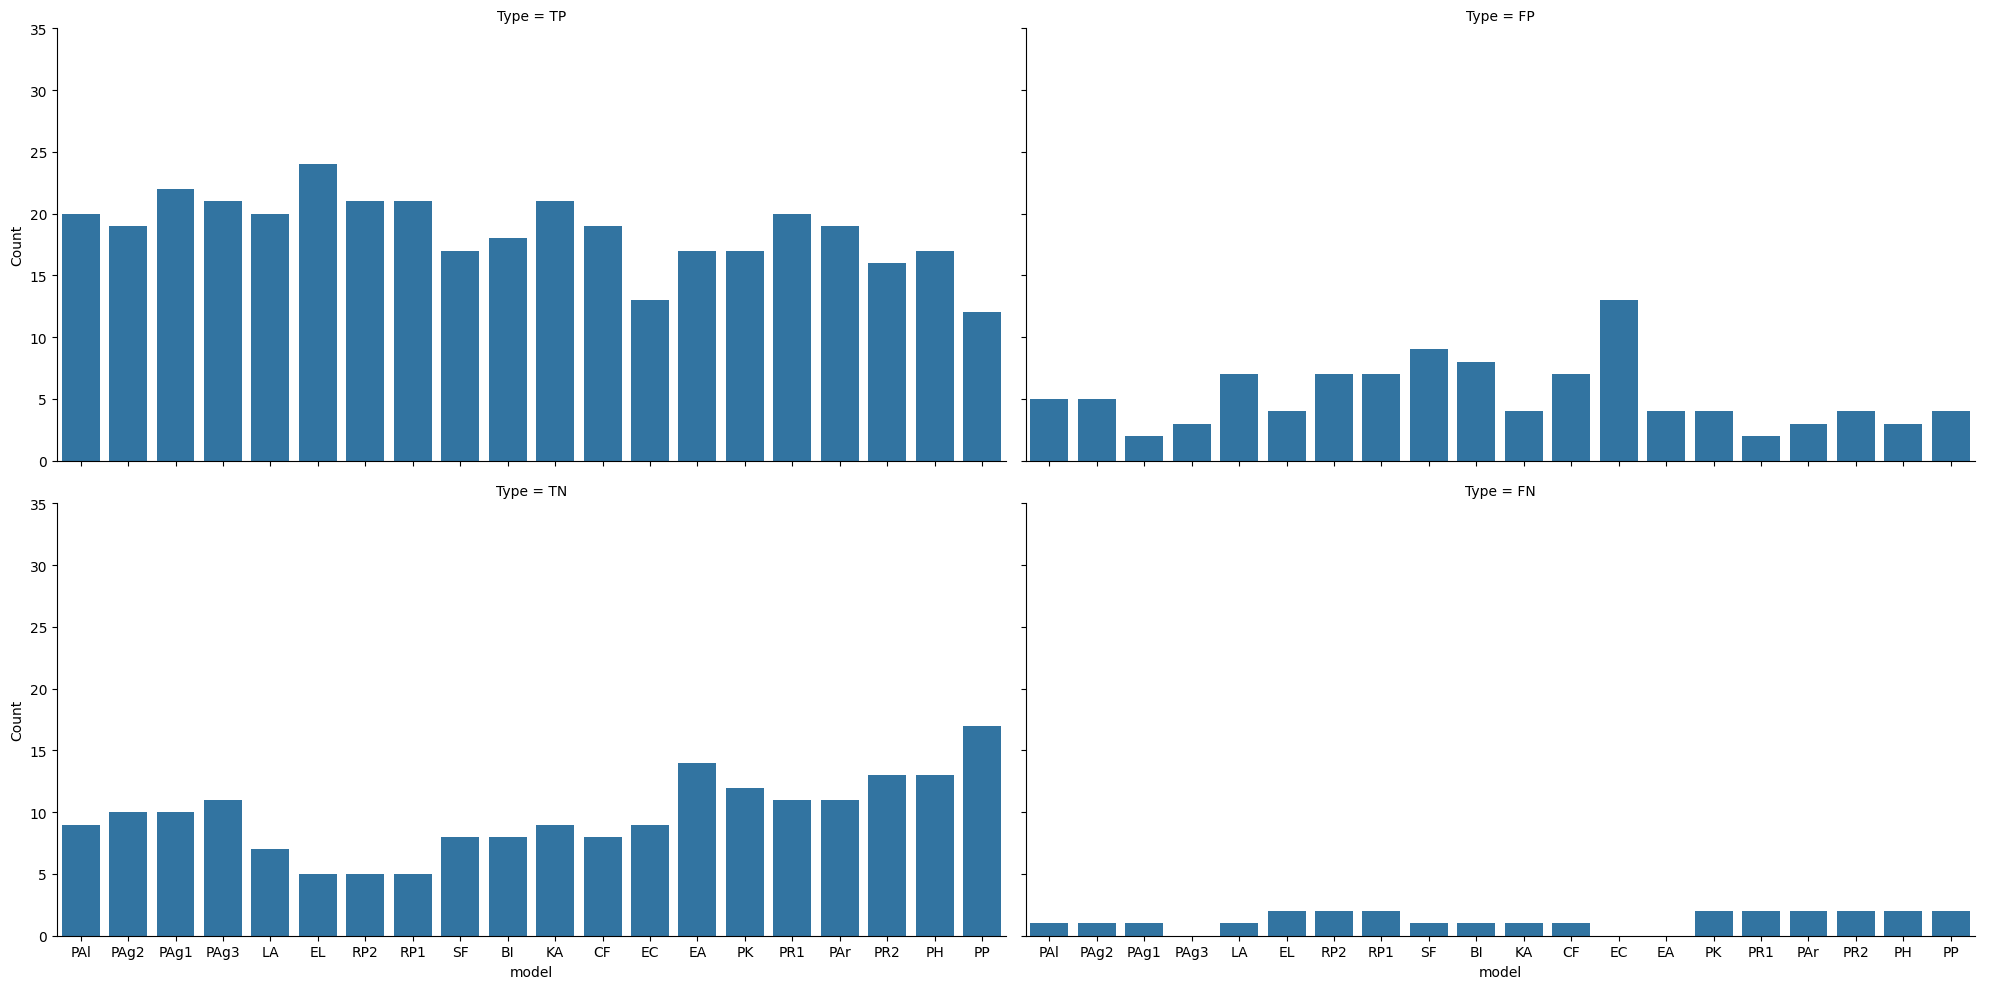

In [18]:
plot_confusion_matrix(pred_data, exp_data)